In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
import compute_charge_dist as fz

import time

%matplotlib inline

Loading the library to compute the charge distribution of dust grains.


In [2]:
def function_sigma_pos(x, aa, bb, hh):
    sigma_par = aa*(1. - np.exp(-x[:]/hh)) + bb
    return sigma_par

def function_sigma_neg(x, aa, bb, hh):
    sigma_par = aa*(1. - np.exp(x[:]/hh)) + bb
    return sigma_par

In [153]:
grain_type = "carbonaceous"
#grain_type = "silicate"

grain_size = 1000
pcent      = 0.1

# Desktop
save_dir = "/home/jcibanezm/Dropbox/codes/run/ChargeStatisticsAnalysis/Daikaiju"
filename = "fz_%.4iAA_%s_CR_True_%i_pcent.pkl"%(grain_size, grain_type, pcent) 
pkl_file    = open("%s/%s"%(save_dir, filename), "rb")
cdist = pickle.load(pkl_file)
pkl_file.close

too_high = np.where(cdist["nH"] > 2.0e4)

ii = 0
for key in cdist.keys():
    if key!="Qabs_mean" and key!="grain_size" and key!="grain_type" and key!="MPI" and key!="fdist" and key!="info" and key!="zminmax" and key!="ZZ":
        cdist[key] = np.delete(cdist[key], too_high)

cdist_pos = cdist.copy()
cdist_neg = cdist.copy()

positive = np.where(cdist_pos["zmean"] >= 0.0)
negative = np.where(cdist_neg["zmean"] <  0.0)

ii = 0
for key in cdist.keys():
    if key!="Qabs_mean" and key!="grain_size" and key!="grain_type" and key!="MPI" and key!="fdist" and key!="info" and key!="zminmax":
        cdist_neg[key] = np.delete(cdist_neg[key], positive)
        cdist_pos[key] = np.delete(cdist_pos[key], negative)

largeZ  = np.where(abs(cdist_pos["zmean"]) > 1.0e-5)
Zstd_smallGTn = np.delete(cdist_pos["zstd"], largeZ)
Zstd_avg_GTnsmall = np.mean(Zstd_smallGTn)

print(Zstd_avg_GTnsmall)

nan


In [157]:
largeZ  = np.where(abs(cdist_pos["zmean"]) > 1.0e-3)
Zstd_smallGTn = np.delete(cdist_pos["zstd"], largeZ)
Zstd_avg_GTnsmall = np.mean(Zstd_smallGTn)

print(Zstd_avg_GTnsmall)

0.908584587255


In [158]:
popt_zstd_pos, pcov_zstd_pos = curve_fit(function_sigma_pos, cdist_pos["zmean"], cdist_pos["zstd"], p0=[0.3, Zstd_avg_GTnsmall, 0.3], bounds=([-np.inf, Zstd_avg_GTnsmall*0.999, -np.inf], [np.inf, Zstd_avg_GTnsmall*1.001, np.inf])) 
popt_zstd_neg, pcov_zstd_neg = curve_fit(function_sigma_neg, cdist_neg["zmean"], cdist_neg["zstd"], p0=[0.3, popt_zstd_pos[1], 0.3], bounds=([-np.inf, popt_zstd_pos[1]*0.999, -np.inf], [np.inf, popt_zstd_pos[1]*1.001, np.inf])) 

In [84]:
#popt_zstd_pos, pcov_zstd_pos = curve_fit(function_sigma_pos, cdist_pos["zmean"], cdist_pos["zstd"], p0=[0.3, Zstd_avg_GTnsmall, 0.3], bounds=([-np.inf, Zstd_avg_GTnsmall*0.999, -np.inf], [np.inf, Zstd_avg_GTnsmall*1.001, np.inf]))
#popt_zstd_neg, pcov_zstd_neg = curve_fit(function_sigma_neg, cdist_neg["zmean"], cdist_neg["zstd"], bounds=([0.0, popt_zstd_pos[1]*0.999, 0.0], [10.0, popt_zstd_pos[1]*1.001, 1.0]),p0=[0.0, popt_zstd_pos[1], 0.5])

In [159]:
print("\t a \t b \t h")
print(popt_zstd_pos)
print(popt_zstd_neg)

	 a 	 b 	 h
[  8.70032149   0.90949317  36.10147476]
[ -2.60095052e+03   9.10402665e-01   4.70296490e+03]


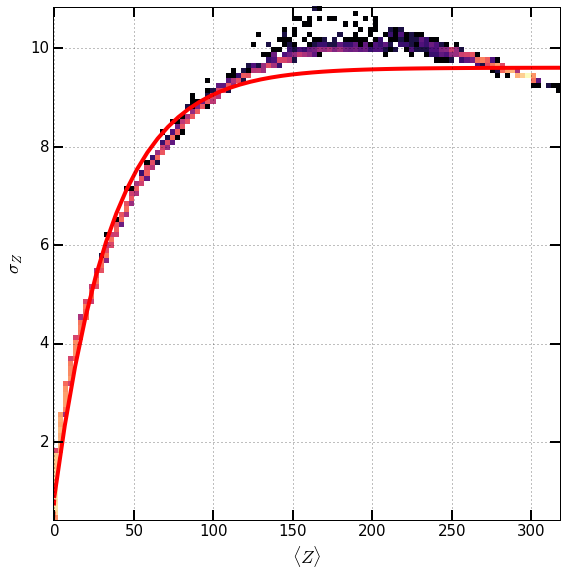

In [161]:
xsize = 8
ysize = 8

nfigs_x = 1
nfigs_y = 1

fig = plt.figure(figsize=(xsize, ysize))

hpad = 0.09
wpad = 0.11

xs_panel = 0.88 / nfigs_x 
ys_panel = 0.89 / nfigs_y 

############################################################################################################
############################               XX Angstroms             #######################################
############################################################################################################

ii = 0
jj = 0

ax = fig.add_axes([wpad + ii*xs_panel+ii*wpad, hpad + jj*ys_panel, xs_panel, ys_panel])

ax.hist2d(cdist["zmean"], cdist["zstd"], bins=100, norm=LogNorm(), normed=True, cmap="magma")
#ax.hist2d(cdist["zmean"], cdist["zstd"], bins=100, norm=LogNorm(), normed=True, cmap="magma", range=[[-1.0, 0.01],[0.4, 0.7]])


zmean_arr_pos = np.linspace(np.min(cdist_pos["zmean"]), np.max(cdist_pos["zmean"]))
NewPar        = function_sigma_pos(zmean_arr_pos, *popt_zstd_pos)
ax.plot(zmean_arr_pos, NewPar, "-r", linewidth=4)

zmean_arr_neg = np.linspace(np.min(cdist_neg["zmean"]), np.max(cdist_neg["zmean"]))
NewPar_neg        = function_sigma_neg(zmean_arr_neg, *popt_zstd_neg)
#NewPar_neg     = function_sigma_neg(zmean_arr_neg, 0.2890, popt_zstd_pos[1], 1.6241)
ax.plot(zmean_arr_neg, NewPar_neg, "--r", linewidth=4)

ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=15, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=15, direction="in")

ax.set_ylabel("$\\sigma_{Z}$", fontsize=18)
ax.set_xlabel("$\\langle Z \\rangle$", fontsize=18)

ax.grid("on")

#ax.set_ylim(0.98*np.min(cdist["zstd"]), 1.02*np.max(cdist["zstd"]))
#ax.set_ylim(0.5, 0.6)
#ax.set_xlim(-0.5, 0.0)

fig.show()